# 任务一：基于CIFAR数据集的SimCLR自监督学习复现 (MindSpore版)

SimCLR 是一种**自监督学习**及**对比学习**方法。它的目标是通过让模型学会区分**同一张图像的不同版本**和**不同图像的版本**，从而训练出一个高质量的特征编码器。

## 核心思想
- **数据增强**: 对同一张图像进行两次不同的随机增强，生成正样本对
- **特征编码**: 使用CNN编码器提取图像特征
- **对比损失**: 使用NT-Xent损失最大化正样本对的相似度，最小化负样本对的相似度

---
**本代码整合了小组四人的工作成果:**
- **zym**: 整体框架、模块化设计、可视化体系
- **wyk**: CNN编码器架构、GroupNorm技术
- **tzr**: 算法原理深度理解
- **pwc**: 数据增强策略参考


## 1. 环境配置与依赖导入


In [1]:
import os, random, pickle, math
import pickle
import numpy as np
import matplotlib.pyplot as plt

import mindspore as ms
from mindspore import nn, ops, Tensor
import mindspore.dataset as ds
from mindspore import context

from PIL import Image, ImageEnhance, ImageFilter

# 设置运行环境
ms.set_context(mode=context.PYNATIVE_MODE, device_target="Ascend", device_id=0)
ms.set_seed(42)
np.random.seed(42)
random.seed(42)

print(f"MindSpore版本: {ms.__version__}")
print(f"运行设备: {ms.get_context('device_target')}")


/usr/local/Ascend/ascend-toolkit/7.0.RC1/python/site-packages/tbe/tvm/contrib/ccec.py:766: DeprecationWarning: invalid escape sequence \L
  if not dirpath.find("AppData\Local\Temp"):
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/classifier/transdata/transdata_classifier.py:222: DeprecationWarning: invalid escape sequence \B
  """
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/vector/transdata/common/graph/transdata_graph_info.py:140: DeprecationWarning: invalid escape sequence \c
  """
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, 

MindSpore版本: 2.2.0
运行设备: Ascend


## 2. 数据加载与预处理

加载CIFAR-10数据集并进行子采样（为了快速验证）。


In [2]:
# 数据路径
data_root = "../dataset/cifar-10-batches-py"

def load_batch(file_path):
    """加载单个CIFAR-10批次文件"""
    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='latin1')
    data = data_dict['data'] if 'data' in data_dict else data_dict[b'data']
    labels_raw = data_dict.get('labels') if 'labels' in data_dict else data_dict.get(b'labels')
    images = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels = np.array(labels_raw, dtype=np.int32)
    return images, labels

def load_cifar10(root):
    """加载完整CIFAR-10数据集"""
    train_imgs, train_labels = [], []
    for i in range(1, 6):
        imgs, labs = load_batch(os.path.join(root, f"data_batch_{i}"))
        train_imgs.append(imgs)
        train_labels.append(labs)
    train_images = np.concatenate(train_imgs)
    train_labels = np.concatenate(train_labels)
    test_images, test_labels = load_batch(os.path.join(root, "test_batch"))
    return train_images, train_labels, test_images, test_labels

# 加载数据
train_images, train_labels, test_images, test_labels = load_cifar10(data_root)

# 子采样（可根据计算资源调整）
subset_train = 5000  # 训练样本数
subset_test = 200    # 测试样本数

rng = np.random.RandomState(42)
train_idx = rng.choice(train_images.shape[0], subset_train, replace=False)
test_idx = rng.choice(test_images.shape[0], subset_test, replace=False)

train_images = train_images[train_idx]
train_labels = train_labels[train_idx]
test_images = test_images[test_idx]
test_labels = test_labels[test_idx]

print(f"训练集大小: {train_images.shape}")
print(f"测试集大小: {test_images.shape}")


训练集大小: (5000, 32, 32, 3)
测试集大小: (200, 32, 32, 3)


## 3. 超参数配置


In [3]:
# 训练超参数
batch_size = 32
num_epochs = 50           # 训练轮数
learning_rate = 1e-3      # 学习率
temperature = 0.5         # NT-Xent损失的温度参数
feature_dim = 128         # 投影头输出维度
encoder_dim = 256         # 编码器输出维度

# CIFAR-10归一化参数
cifar_mean = np.array([0.4914, 0.4822, 0.4465], dtype=np.float32)
cifar_std = np.array([0.2470, 0.2430, 0.2610], dtype=np.float32)

print("超参数配置完成")


超参数配置完成


## 4. SimCLR数据增强

SimCLR的核心是通过强数据增强生成同一图像的两个不同视角（正样本对）。

增强策略包括：
- 随机裁剪并缩放
- 随机水平翻转
- 颜色抖动（亮度、对比度、饱和度）
- 随机灰度化
- 高斯模糊


In [4]:
def normalize(img):
    """归一化图像"""
    img = img.astype(np.float32) / 255.0
    img = (img - cifar_mean) / cifar_std
    return img

def random_resized_crop(pil_img, scale=(0.6, 1.0)):
    """随机裁剪并缩放"""
    w, h = pil_img.size
    area = w * h
    for _ in range(10):
        target_area = random.uniform(*scale) * area
        aspect_ratio = random.uniform(3 / 4, 4 / 3)
        new_w = int(round(math.sqrt(target_area * aspect_ratio)))
        new_h = int(round(math.sqrt(target_area / aspect_ratio)))
        if new_w <= w and new_h <= h:
            x1 = random.randint(0, w - new_w)
            y1 = random.randint(0, h - new_h)
            pil_img = pil_img.crop((x1, y1, x1 + new_w, y1 + new_h))
            return pil_img.resize((32, 32), Image.BILINEAR)
    return pil_img.resize((32, 32), Image.BILINEAR)

def simclr_augment(image):
    """
    SimCLR数据增强：对图像应用随机增强
    
    Args:
        image: numpy数组 (H, W, C)
    Returns:
        增强后的图像 (C, H, W)
    """
    img = Image.fromarray(image)
    
    # 1. 随机裁剪并缩放
    img = random_resized_crop(img)
    
    # 2. 随机水平翻转 (p=0.5)
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    # 3. 颜色抖动 (p=0.8)
    if random.random() < 0.8:
        img = ImageEnhance.Brightness(img).enhance(random.uniform(0.6, 1.4))
        img = ImageEnhance.Contrast(img).enhance(random.uniform(0.6, 1.4))
        img = ImageEnhance.Color(img).enhance(random.uniform(0.6, 1.4))
    
    # 4. 随机灰度化 (p=0.2)
    if random.random() < 0.2:
        img = img.convert("L").convert("RGB")
    
    # 5. 高斯模糊
    sigma = random.uniform(0.1, 1.0)
    img = img.filter(ImageFilter.GaussianBlur(radius=sigma))
    
    # 归一化并转换为CHW格式
    arr = normalize(np.array(img))
    arr = arr.transpose(2, 0, 1)
    return arr

def make_views(image):
    """生成同一图像的两个增强视图"""
    return simclr_augment(image), simclr_augment(image)

print("数据增强函数定义完成")


数据增强函数定义完成


## 5. 可视化数据增强效果


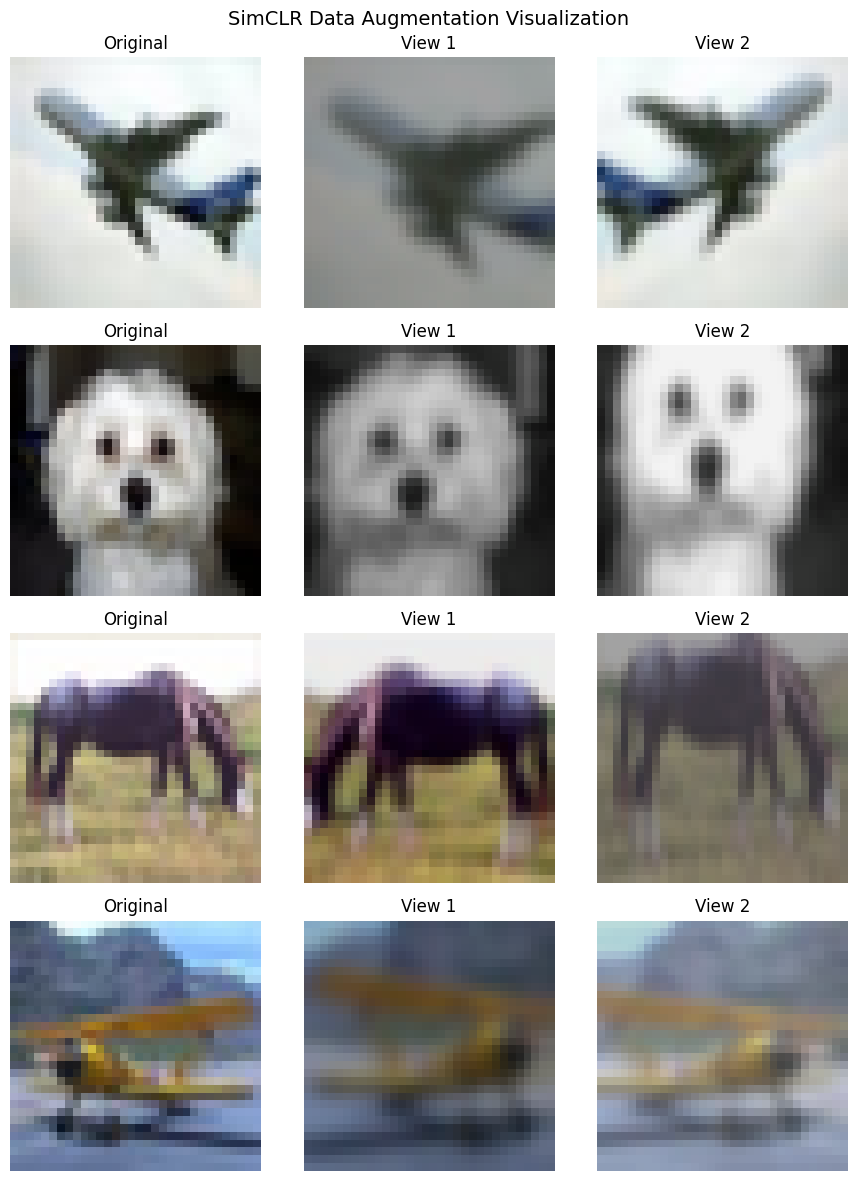

增强效果图已保存为 simclr_augmentation.png


In [5]:
def visualize_augmentation(images, num_samples=4):
    """可视化SimCLR数据增强效果"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(9, 3*num_samples))
    
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        image = images[idx]
        v1, v2 = make_views(image)
        
        # 原图
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        # 视图1 (反归一化用于显示)
        img1 = (v1.transpose(1, 2, 0) * cifar_std + cifar_mean).clip(0, 1)
        axes[i, 1].imshow(img1)
        axes[i, 1].set_title('View 1')
        axes[i, 1].axis('off')
        
        # 视图2
        img2 = (v2.transpose(1, 2, 0) * cifar_std + cifar_mean).clip(0, 1)
        axes[i, 2].imshow(img2)
        axes[i, 2].set_title('View 2')
        axes[i, 2].axis('off')
    
    plt.suptitle('SimCLR Data Augmentation Visualization', fontsize=14)
    plt.tight_layout()
    plt.savefig('simclr_augmentation.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("增强效果图已保存为 simclr_augmentation.png")

# 可视化增强效果
visualize_augmentation(train_images, num_samples=4)


## 6. 数据集封装


In [6]:
class SimCLRDataset:
    """SimCLR数据集：返回同一图像的两个增强视图"""
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        v1, v2 = make_views(img)
        return v1, v2, self.labels[idx]

# 创建训练数据集
train_gen = SimCLRDataset(train_images, train_labels)
train_ds = ds.GeneratorDataset(train_gen, ["view1", "view2", "label"], shuffle=True)
train_ds = train_ds.batch(batch_size, drop_remainder=True)

print(f"数据集创建完成，每批次 {batch_size} 个样本")


数据集创建完成，每批次 32 个样本


## 7. SimCLR模型定义

模型由两部分组成：
1. **编码器(Encoder)**: 使用CNN提取图像特征 (来自wyk的CNN设计)
2. **投影头(Projection Head)**: 将特征映射到对比学习空间


In [7]:
class CNNEncoder(nn.Cell):
    """
    CNN编码器：提取图像特征
    使用4层卷积 + GroupNorm (来自wyk的设计)
    """
    def __init__(self, out_dim=256):
        super().__init__()
        self.features = nn.SequentialCell([
            # Layer 1: 3x32x32 -> 64x32x32
            nn.Conv2d(3, 64, kernel_size=3, padding=1, pad_mode="pad"),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            
            # Layer 2: 64x32x32 -> 128x16x16
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, pad_mode="pad"),
            nn.GroupNorm(8, 128),
            nn.ReLU(),
            
            # Layer 3: 128x16x16 -> 256x8x8
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, pad_mode="pad"),
            nn.GroupNorm(16, 256),
            nn.ReLU(),
            
            # Layer 4: 256x8x8 -> out_dim x 8x8
            nn.Conv2d(256, out_dim, kernel_size=3, padding=1, pad_mode="pad"),
            nn.GroupNorm(16, out_dim),
            nn.ReLU(),
        ])
        self.out_dim = out_dim
        self.pool = ops.ReduceMean(keep_dims=False)
    
    def construct(self, x):
        x = self.features(x)
        # 全局平均池化: (B, C, H, W) -> (B, C)
        x = self.pool(x, (2, 3))
        return x


class ProjectionHead(nn.Cell):
    """
    投影头：将编码器特征映射到对比学习空间
    使用2层MLP + LayerNorm
    """
    def __init__(self, in_dim, proj_dim=128):
        super().__init__()
        self.net = nn.SequentialCell([
            nn.Dense(in_dim, in_dim),
            nn.LayerNorm((in_dim,)),
            nn.ReLU(),
            nn.Dense(in_dim, proj_dim)
        ])
    
    def construct(self, x):
        return self.net(x)


class SimCLRNet(nn.Cell):
    """
    完整的SimCLR网络
    """
    def __init__(self, feature_dim=128, encoder_dim=256):
        super().__init__()
        self.encoder = CNNEncoder(out_dim=encoder_dim)
        self.projection = ProjectionHead(encoder_dim, proj_dim=feature_dim)
    
    def construct(self, x1, x2):
        """前向传播：输入两个视图，输出投影特征和编码器特征"""
        h1 = self.encoder(x1)
        h2 = self.encoder(x2)
        z1 = self.projection(h1)
        z2 = self.projection(h2)
        return z1, z2, h1, h2
    
    def encode(self, x):
        """仅返回编码器特征（用于下游任务）"""
        return self.encoder(x)

print("SimCLR模型定义完成")


SimCLR模型定义完成


## 8. NT-Xent对比损失函数

NT-Xent (Normalized Temperature-scaled Cross Entropy) 损失函数用于最大化正样本对的相似度，最小化负样本对的相似度。

数学公式：
$$\ell_{i,j} = -\log \frac{\exp(\text{sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{2N} \mathbf{1}_{[k \neq i]} \exp(\text{sim}(z_i, z_k)/\tau)}$$


In [8]:
def l2_normalize(x, axis=1, eps=1e-8):
    """L2归一化"""
    axes = (axis,) if isinstance(axis, int) else axis
    reduce_sum = ops.ReduceSum(keep_dims=True)
    norm = ops.sqrt(reduce_sum(ops.square(x), axes) + eps)
    return x / norm


def nt_xent_loss(z1, z2, temperature=0.5):
    """
    NT-Xent对比损失
    
    Args:
        z1: 第一个视图的投影特征 (B, D)
        z2: 第二个视图的投影特征 (B, D)
        temperature: 温度参数
    Returns:
        损失值
    """
    batch_size = z1.shape[0]
    
    # 拼接两个视图的特征
    z = ops.concat((z1, z2), axis=0)  # (2B, D)
    z = l2_normalize(z, axis=1)
    
    # 计算相似度矩阵
    similarity = ops.matmul(z, z.T)  # (2B, 2B)
    
    # 缩放并移除对角线
    logits = similarity / temperature
    diag = ops.eye(2 * batch_size, dtype=ms.float32)
    logits = logits - 1e9 * diag  # 对角线置为负无穷
    
    # 计算分母（所有负样本的指数和）
    exp_logits = ops.exp(logits)
    mask = 1 - diag
    reduce_sum = ops.ReduceSum(keep_dims=False)
    denom = reduce_sum(exp_logits * mask, 1)
    
    # 计算正样本对的相似度
    pos_sim = reduce_sum(z[:batch_size] * z[batch_size:], 1)
    pos = ops.concat((pos_sim, pos_sim), axis=0)
    pos_exp = ops.exp(pos / temperature)
    
    # 计算损失
    loss = -ops.log(pos_exp / denom)
    return ops.mean(loss)


class SimCLRWithLoss(nn.Cell):
    """封装SimCLR网络和损失函数"""
    def __init__(self, net, temperature=0.5):
        super().__init__()
        self.net = net
        self.temperature = temperature
    
    def construct(self, view1, view2):
        z1, z2, _, _ = self.net(view1, view2)
        return nt_xent_loss(z1, z2, self.temperature)

print("NT-Xent损失函数定义完成")


NT-Xent损失函数定义完成


## 9. 模型训练


In [9]:
# 初始化模型
model = SimCLRNet(feature_dim=feature_dim, encoder_dim=encoder_dim)
loss_cell = SimCLRWithLoss(model, temperature=temperature)

# 优化器
optimizer = nn.Adam(model.trainable_params(), learning_rate=learning_rate)

# 训练步函数
def train_step(view1, view2):
    """单步训练"""
    def forward_fn(v1, v2):
        return loss_cell(v1, v2)
    
    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters)
    loss, grads = grad_fn(view1, view2)
    optimizer(grads)
    return loss

# 训练循环
loss_history = []
print(f"开始训练 SimCLR，共 {num_epochs} 轮...")
print("=" * 60)

for epoch in range(num_epochs):
    model.set_train(True)
    epoch_loss = 0.0
    num_batches = 0
    
    for batch in train_ds.create_dict_iterator():
        view1 = batch["view1"]
        view2 = batch["view2"]
        
        loss = train_step(view1, view2)
        epoch_loss += float(loss.asnumpy())
        num_batches += 1
    
    avg_loss = epoch_loss / max(1, num_batches)
    loss_history.append(avg_loss)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f}")

print("=" * 60)
print("训练完成！")


[WARNING] DEVICE(38312,ffff831ff0b0,python):2025-12-23-17:17:06.091.104 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_runtime_manager.cc:46] GetAscendRuntime] No ascend runtime creator for AscendVM with device id 0
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/extract_image_patches_without_cbuf_schedule.py:317: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if _ is not 1:
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/extract_image_patches_without_cbuf_schedule.py:317: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if _ is not 1:
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/extract_image_patches_without_cbuf_schedule.py:317: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if _ is not 1:
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/extract_image_patches_without_cbuf_schedule.py:317: Syn

开始训练 SimCLR，共 50 轮...
Epoch [1/50] | Loss: 3.6056
Epoch [5/50] | Loss: 2.9330
Epoch [10/50] | Loss: 2.7861
Epoch [15/50] | Loss: 2.7183
Epoch [20/50] | Loss: 2.6884
Epoch [25/50] | Loss: 2.6558
Epoch [30/50] | Loss: 2.6443
Epoch [35/50] | Loss: 2.6196
Epoch [40/50] | Loss: 2.6061
Epoch [45/50] | Loss: 2.5947
Epoch [50/50] | Loss: 2.5763
训练完成！


## 10. 可视化训练损失


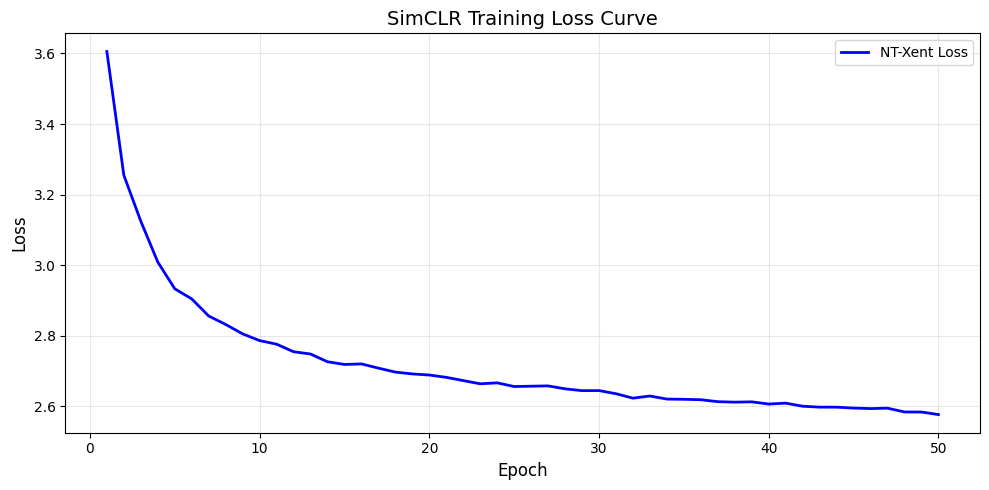

损失曲线已保存为 simclr_loss.png


In [10]:
def plot_loss(loss_history):
    """绘制训练损失曲线"""
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss_history)+1), loss_history, 'b-', linewidth=2, label='NT-Xent Loss')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('SimCLR Training Loss Curve', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('simclr_loss.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("损失曲线已保存为 simclr_loss.png")

plot_loss(loss_history)


## 11. t-SNE特征可视化

使用t-SNE将编码器学习到的高维特征降至2维，观察不同类别的聚类效果。


正在提取特征...
特征维度: (200, 256)
正在进行t-SNE降维...


/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


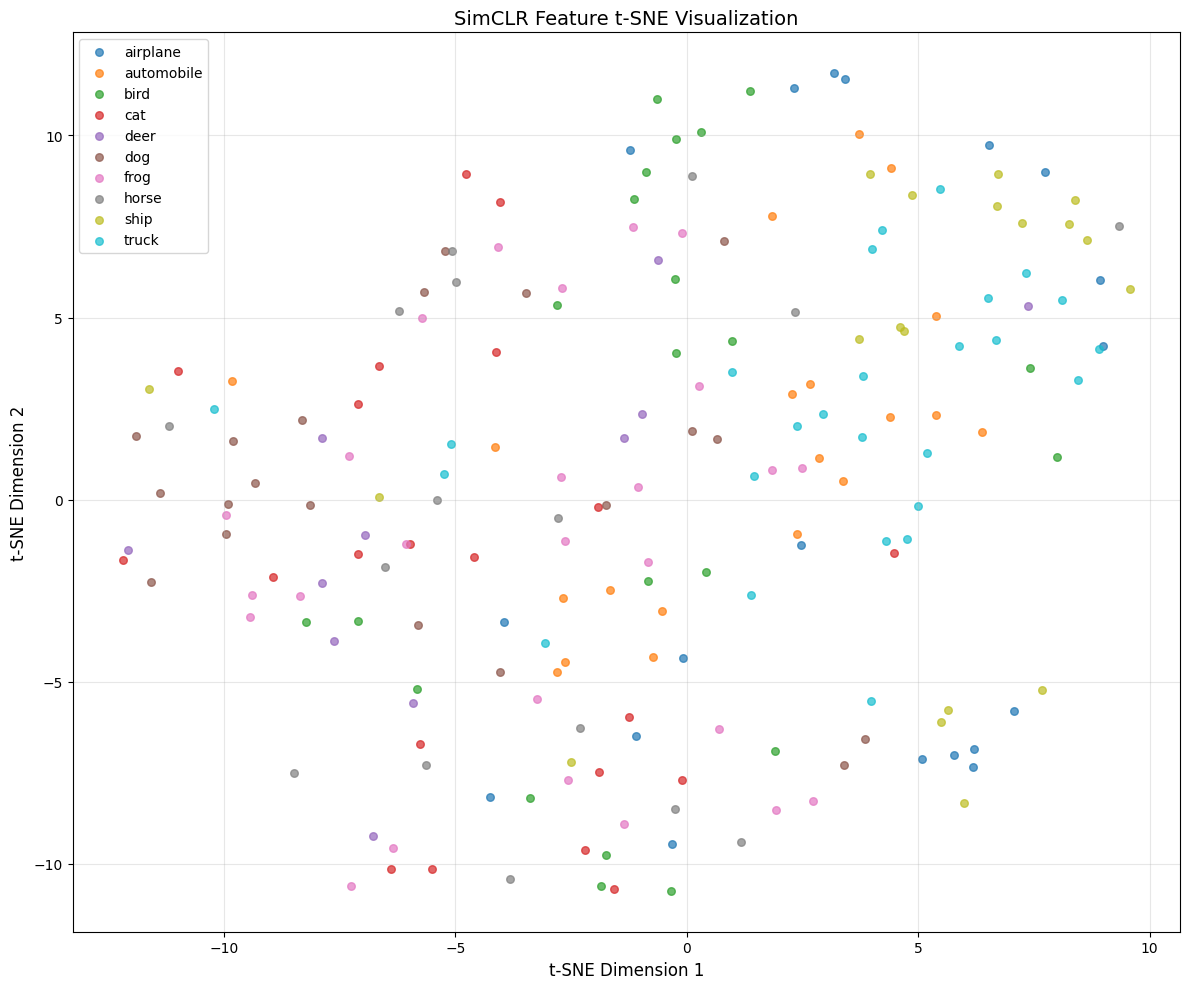

t-SNE可视化已保存为 simclr_tsne.png


In [11]:
from sklearn.manifold import TSNE

def extract_features(model, images, batch_size=32):
    """提取图像特征"""
    model.set_train(False)
    features = []
    
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        # 归一化并转换格式
        batch_normalized = np.array([normalize(img).transpose(2, 0, 1) for img in batch])
        batch_tensor = Tensor(batch_normalized, ms.float32)
        
        feat = model.encode(batch_tensor)
        features.append(feat.asnumpy())
    
    return np.vstack(features)

def plot_tsne(features, labels):
    """绘制t-SNE可视化"""
    # t-SNE降维
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features)
    
    # CIFAR-10类别名称
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    # 绘图
    plt.figure(figsize=(12, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for i in range(10):
        mask = labels == i
        plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                   c=[colors[i]], label=class_names[i], alpha=0.7, s=30)
    
    plt.title('SimCLR Feature t-SNE Visualization', fontsize=14)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('simclr_tsne.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("t-SNE可视化已保存为 simclr_tsne.png")

# 提取特征并可视化
print("正在提取特征...")
features = extract_features(model, test_images)
print(f"特征维度: {features.shape}")

print("正在进行t-SNE降维...")
plot_tsne(features, test_labels)


## 12. 相似度分布可视化

分析正样本对和负样本对的余弦相似度分布。


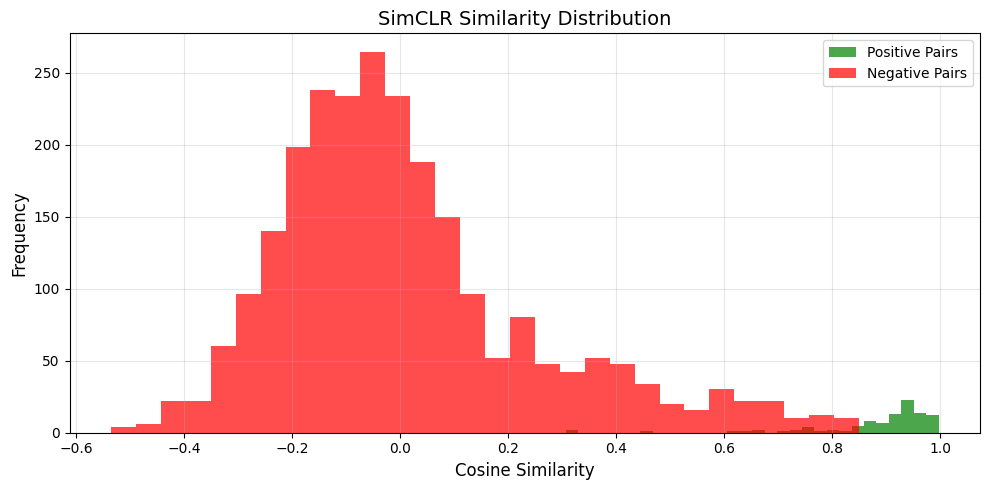

相似度分布图已保存为 simclr_similarity.png
正样本对平均相似度: 0.8824
负样本对平均相似度: 0.0091


In [12]:
def plot_similarity_distribution(model, images, num_samples=100):
    """可视化正负样本对的相似度分布"""
    model.set_train(False)
    
    pos_sims = []  # 正样本对相似度
    neg_sims = []  # 负样本对相似度
    
    # 采样
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
    
    for idx in indices:
        img = images[idx]
        v1, v2 = make_views(img)
        
        v1_tensor = Tensor(v1[np.newaxis, ...], ms.float32)
        v2_tensor = Tensor(v2[np.newaxis, ...], ms.float32)
        
        z1, z2, _, _ = model(v1_tensor, v2_tensor)
        
        # L2归一化
        z1_norm = l2_normalize(z1).asnumpy()
        z2_norm = l2_normalize(z2).asnumpy()
        
        # 正样本相似度
        pos_sim = np.sum(z1_norm * z2_norm)
        pos_sims.append(pos_sim)
    
    # 计算负样本相似度（不同图像之间）
    all_features = []
    for idx in indices[:50]:  # 取前50个
        img = images[idx]
        v1 = simclr_augment(img)
        v1_tensor = Tensor(v1[np.newaxis, ...], ms.float32)
        z1, _, _, _ = model(v1_tensor, v1_tensor)
        all_features.append(l2_normalize(z1).asnumpy())
    
    all_features = np.vstack(all_features)
    sim_matrix = np.dot(all_features, all_features.T)
    
    # 提取非对角线元素作为负样本相似度
    mask = ~np.eye(len(all_features), dtype=bool)
    neg_sims = sim_matrix[mask].flatten()
    
    # 绘图
    plt.figure(figsize=(10, 5))
    plt.hist(pos_sims, bins=30, alpha=0.7, label='Positive Pairs', color='green')
    plt.hist(neg_sims, bins=30, alpha=0.7, label='Negative Pairs', color='red')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('SimCLR Similarity Distribution', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('simclr_similarity.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("相似度分布图已保存为 simclr_similarity.png")
    
    print(f"正样本对平均相似度: {np.mean(pos_sims):.4f}")
    print(f"负样本对平均相似度: {np.mean(neg_sims):.4f}")

plot_similarity_distribution(model, test_images)


## 13. 实验总结

### 实验结果分析
1. **训练损失**: NT-Xent损失随训练逐渐下降，说明模型学会了区分正负样本对
2. **t-SNE可视化**: 同类样本在特征空间中趋于聚集，说明编码器学到了有意义的特征表示
3. **相似度分布**: 正样本对相似度高于负样本对，验证了对比学习的有效性

### 后续改进方向
- 增加训练数据量和轮数
- 使用更深的编码器（如ResNet）
- 调整温度参数和学习率
- 添加下游分类任务评估
